### Imports

In [1]:
import numpy as np
import pygame as pg
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, BasicAer
from qiskit.compiler import transpile
from qiskit.extensions import RXGate, CnotGate, XGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_state_city
from qiskit.providers.aer import StatevectorSimulator

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


### Game Vars 

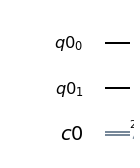

In [2]:
#define colours
BLACK = (0,0,0)
WHITE = (255,255,255)
GREEN = (0,255,0)
RED = (255,0,0)

#Set width and height of the grid location
WIDTH = 20
HEIGHT = 20

#set margins between each cell
MARGIN = 5

#Create 2-D array as a list of lists
grid_size = 3

# Here we initialise our quantum and classical register
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

# Construct the circuit
circ = QuantumCircuit(qr, cr)
circ.draw(output='mpl')
backend = Aer.get_backend('statevector_simulator')
# Add some gates
#circ_1.h([0,1,2])
#circ.h(qr)

#circ_1.x([0,1])
#circ.x(qr)

#circ.measure(qr,cr)

# Draw!
circ.draw(output='mpl')

### Make grid 

In [3]:
grid = []

for row in range(grid_size):
    #add empty array  that will hold each cell in row
    grid.append([])
    for column in range(grid_size):
        grid[row].append(0) # append a cell
    

### Inialise pygame 

In [ ]:
pg.init()

WINDOW_SIZE = [255,255]
screen = pg.display.set_mode(WINDOW_SIZE)


#set title of screen
pg.display.set_caption("Qiskit Game")

#loop until user clicks close button
done = False

#manage speed of screen updates
clock = pg.time.Clock()

def move_player(pos,d):
    x = pos[0]
    y = pos[1]
    pos = None
    
    #for i in range(len(pos//2)):
    if len(pos) == 2:
        if d[0] == 'r':
            pos = (x + 1, y)
        if d[0] == 'l':
            pos = (x - 1, y)
        if d[0] == 'u':
            pos = (x, y - 1)
        if d[0] == 'd':
            pos = (x, y + 1)
        
    
    if len(pos) == 4:
        if d[0] == 'r':
            pos = (x + 1, y,x - 1, y)
        if d[0] == 'l':
            pos = (x - 1, y,x + 1, y)
        if d[0] == 'u':
            pos = (x, y - 1,x, y+1)
        if d[0] == 'd':
            pos = (x, y + 1,x, y-1)
        
    return pos

def get_dir(state_vector):
    #x = pos[0]
    #y = pos[1]
    #pos = None
    print(state_vector)
    if (state_vector == np.array([0,1,0,0])).all():
        direction = 'r'
    if (state_vector == np.array([0,0,1,0])).all():
        direction = 'l'
    if (state_vector == np.array([1,0,0,0])).all():
        direction = 'u'
    if (state_vector == np.array([0,0,0,1])).all():
        direction = 'd'
        
    #Account for Hadamar
    if (state_vector == np.array([0.5,0.5,0,0])).all():
        direction = 'ur'
    if (state_vector == np.array([0,0.5,0.5,0])).all():
        direction = 'ul'
    if (state_vector == np.array([0,0,0.5,0.5])).all():
        direction = 'dl'  
    if (state_vector == np.array([0.5,0,0,0.5])).all():
        direction = 'du'
        
    return direction

def mod_circ(circ,gate,qubit):
    
    if gate  == "H":
        circ.h(qubit)
        
    if gate  == "X":
        circ.x(qubit)
        
    if gate  == "cNOT":     
        if qubit == 0:
            circ.cx(0,1)
        else:
            circ.cx(1,0)
            
    if gate  == "ID":
        circ.IdGate(qubit)
        
    return circ
        
        


#---------------------MAIN LOOP-----------------------------------#
pos = [0,0]
players = 1

while not done:
    
    for event in pg.event.get(): # user did a thing
        if event.type == pg.QUIT: # if the user clicked close
            done = True
        elif event.type == pg.MOUSEBUTTONDOWN:
            #user clicks mouse get the position
            pos = pg.mouse.get_pos()
            #change x/y screen coordinates to  grid coordinates
            column = pos[0]//(WIDTH + MARGIN)
            row = pos[1]//(HEIGHT+MARGIN)
            #set that location to one
            grid[row][column] = 1
            print("Click",pos,"Grid_Coords",row,column)
            
        #set screen background
        screen.fill(BLACK)
        
        #Draw the grid
        for row in range(grid_size):
            for column in range(grid_size):
                color = WHITE
                if grid[row][column] == 1:
                    color = GREEN
                pg.draw.rect(screen,
                            color,
                            [(MARGIN + WIDTH)* column + MARGIN,
                            (MARGIN + HEIGHT)* row + MARGIN,
                            WIDTH,
                            HEIGHT])
        
        #start pos
        #grid[0][0] = BLUE
        
        
        #-------SELECT ACTION-----------#
        #select circuit components, TODO: stop until selection over
        d =  None
        d1 = None
        isH = False
        while d1 != "Y":
            #select qubit
            qubit = input("which bit?")
            #select gate
            gate = input("which gate?(X, H, CNOT, ID)")
            
            #add gates
            circ = mod_circ(circ,gate,int(qubit))
            
            #check if splits from hadamar
            if gate == "H":
                players *= 2
                isH = True
                
            circ.draw(output='mpl')
            """
            gate key:
            -X = X
            -H = H
            -cNOT = CNOT
            -identity = ID
            
            """
            #exit
            #get results of circuit selection
            results = execute(circ,backend).result()
            state_vector = results.get_statevector(circ)

            #move to new position
            #TODO: Account for splits
            direction = None
            if isH:
                #create copy
                pos.append(pos[0])
                pos.append(pos[1])
                
            direction = get_dir(np.abs(state_vector)**2)
            d1= input("Done? (Y/N)")
            #if d1 != 'fin':
            #    d = d1
            
            
            
        #---------MOVE PLAYER AND MARK-----------#
        pos = move_player(pos,direction)
        print(pos)
        
        for i in range(len(pos)//2):
            pg.draw.rect(screen,
                        GREEN,
                        [(MARGIN + WIDTH)* pos[i] + MARGIN,
                        (MARGIN + HEIGHT)* pos[i+1] + MARGIN,
                        WIDTH,
                        HEIGHT])
        
        #Limit to 60 fps
        clock.tick(60)       
        # Go ahead and update screen with drawing 
        pg.display.flip()

#close on idle
pg.quite()
        
        



which bit?


In [ ]:
test = [1,0,0,0]

In [ ]:
test

In [ ]:
np.array(test)

In [ ]:
results = execute(circ,backend).result()
state_vector = results.get_statevector(circ)

In [ ]:
np.abs(state_vector)**2